# Задача 

Обучить кодировщик помещать похожие лица рядом.

# Решение

## Среда

In [1]:
#@title Библиотеки
import os
import sys
import random as random
import matplotlib.pyplot as plt 
import matplotlib.image as matimg
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from IPython.display import clear_output, Image as ImagePy 
from PIL import Image 
import imageio 
import time
import datetime
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing import image # для отрисовки изображения
from tensorflow.keras.optimizers import Adam # загружаем выбранный оптимизатор
from tensorflow.keras import utils # загружаем утилиты кераса
from sklearn.model_selection import train_test_split
import json
from tqdm import tqdm 

In [5]:
#@title Параметры
DATA_PATH = 'data' # основной каталог для сохранения и загрузки данных
FACE_PATH = os.path.join(DATA_PATH, 'imgs') # каталог сохранения загрузки фото
COUNT_FACE = 100 # количество скачиваемых фото одного актера
NORM_PATH = os.path.join(DATA_PATH, 'norm') # каталог сохранения нормализованного фото
SHAPE_IN = (320, 320, 3)  # размер нормализации
EPS = 100 # количество эпох финального обучения
BATCH = 32 # размер партий обучения
SIZE_DATASET = 7000 # финальный размер выборки 
TEST_SIZE = 0.1 # процент тестовых данных
COUNT_EXP = 1000 # кол-во экспортируемых фото 
PATH_EXP = os.path.join(DATA_PATH, 'fake')
FILE_EXP = os.path.join(DATA_PATH, 'fake.csv')

## Датасет

In [3]:
#@title Список актеров
with open('actors.json', 'r') as fp:
    dict_act = json.load(fp)
dict_act

{'women': ['Alicia Vikander',
  'Amy Adams',
  'Andie MacDowell',
  'Angelina Jolie',
  'Anne Hathaway',
  'Cameron Diaz',
  'Carey Mulligan',
  'Cate Blanchett',
  'Catherine Zeta-Jones',
  'Charlize Theron',
  'Claire Forlani',
  'Demi Moore',
  'Drew Barrymore',
  'Elizabeth Taylor',
  'Emma Stone',
  'Eva Mendes',
  'Frances McDormand',
  'Gwyneth Paltrow',
  'Halle Berry',
  'Hilary Swank',
  'Jennifer Aniston',
  'Jessica Biel',
  'Jessica Chastain',
  'Jodie Foster',
  'Julia Roberts',
  'Julianne Moore',
  'Juliette Binoche',
  'Kate Winslet',
  'Keira Knightley',
  'Kim Basinger',
  'Kirsten Dunst',
  'Kristin Scott Thomas',
  "Lupita Nyong'o",
  'Maggie Gyllenhaal',
  'Marion Cotillard',
  'Meg Ryan',
  'Megan Fox',
  'Melanie Laurent',
  'Meryl Streep',
  'Michelle Pfeiffer',
  'Milla Jovovich',
  'Naomi Watts',
  'Natalie Portman',
  'Natasha Henstridge',
  'Nicole Kidman',
  'Nina Dobrev',
  'Octavia Spencer',
  'Penélope Cruz',
  'Rachel McAdams',
  'Reese Witherspoon',
 

In [11]:
#@title Парсинг фото
filters = "+filterui:imagesize-large+filterui:color2-color+filterui:photo-photo+filterui:aspect-square+filterui:face-face"
for key in list(dict_act.keys()):
    print(key)
    for face in tqdm(dict_act[key]):
        os.system(f'python bbid.py -s "{face}" -o "{os.path.join(FACE_PATH, face)}" --filters {filters} --limit {COUNT_FACE}')

women


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [15:53<00:00, 15.63s/it]


men


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [19:28<00:00, 15.79s/it]


### Нормализация

In [15]:
#@title Обрезка краев
def crop_img(i, h=320, w=320):
    k = i.size[0]/i.size[1] # разница высоты и ширины
    i = i.resize((int(w*k) if k > 1 else w, int(h/k) if k < 1 else h))
    x1, y1 = (w + (i.size[0]-w)//2, 0) if k > 1 else (0, h+(i.size[1]-h)//2)
    x2, y2 = ((i.size[0]-w)//2, h) if k > 1 else (w, (i.size[1]-h)//2)
    i = i.crop(([x1,x2][k>1], [y1,y2][k<=1], [x1,x2][k<=1], [y1,y2][k>1]))
    return np.array(i)
#@title Расширение краев
def extend_img(i, h=320, w=320):
   k = i.size[0]/i.size[1] # разница высоты и ширины
   bg = Image.new('RGB', (i.size[k<1], i.size[k<1]), (0, 0, 0))
   img_w, img_h = i.size
   bg_w, bg_h = bg.size
   offset = ((bg_w - img_w) // 2, (bg_h - img_h) // 2)
   bg.paste(i, offset)
   i = bg.resize((w, h))
   return np.array(i)

In [18]:
#@title Сохранение
if not os.path.exists(NORM_PATH): os.mkdir(NORM_PATH)
i = 0
for key in list(dict_act.keys()):
    for face in dict_act[key]:
        path = FACE_PATH + os.path.sep + face
        imgs_fnames = os.listdir(path) # получим список изображений 
        for j, fname in tqdm(enumerate(imgs_fnames)): 
            fname = os.path.join(path, fname)
            try:
                arr = Image.open(fname)
                k = arr.size[0]/arr.size[1] # разница высоты и ширины
                if k < 0.9 or k > 1.1:
                  norm = crop_img(arr, *SHAPE_IN[:2])
                else:
                  norm = extend_img(arr, *SHAPE_IN[:2])
                im = Image.fromarray(norm)
                dname = os.path.join(NORM_PATH, face)
                if not os.path.exists(dname): os.mkdir(dname)
                im.save(dname + os.path.sep+ f'{j:03d}.jpg')
                i += 1
            except Exception as er:
                print(er)
print('total count face', i)

23it [00:00, 42.47it/s]
94it [00:01, 59.85it/s]

cannot identify image file 'data\\imgs\\Amy Adams\\Amy-Adams'


185it [00:03, 52.17it/s]
58it [00:01, 39.05it/s]

cannot identify image file 'data\\imgs\\Andie MacDowell\\Andie-MacDowell'


100it [00:01, 53.38it/s]
28it [00:00, 53.61it/s]

cannot write mode RGBA as JPEG


81it [00:01, 47.37it/s]

cannot write mode RGBA as JPEG


185it [00:04, 41.54it/s]
104it [00:03, 32.51it/s]
100it [00:02, 44.78it/s]
36it [00:00, 45.50it/s]

cannot identify image file 'data\\imgs\\Carey Mulligan\\Carey-Mulligan'


71it [00:01, 37.10it/s]
21it [00:00, 30.89it/s]
22it [00:00, 36.01it/s]
0it [00:00, ?it/s]
10it [00:00, 42.46it/s]

cannot identify image file 'data\\imgs\\Claire Forlani\\Claire-Forlani'


16it [00:00, 44.68it/s]
24it [00:00, 34.20it/s]
0it [00:00, ?it/s]
50it [00:01, 38.13it/s]

cannot write mode RGBA as JPEG


100it [00:02, 41.19it/s]
93it [00:03, 29.76it/s]
0it [00:00, ?it/s]
100it [00:03, 30.69it/s]
12it [00:00, 35.30it/s]
33it [00:01, 43.87it/s]

cannot write mode RGBA as JPEG


100it [00:03, 33.21it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100it [00:02, 40.75it/s]
100it [00:02, 38.64it/s]
0it [00:00, ?it/s]
10it [00:00, 25.59it/s]
65it [00:01, 48.68it/s]

cannot identify image file 'data\\imgs\\Julianne Moore\\Julianne-Moore'
cannot identify image file 'data\\imgs\\Julianne Moore\\Julianne-Moore---The-Hunger-Games'


100it [00:02, 44.76it/s]
76it [00:01, 54.03it/s]
0it [00:00, ?it/s]
21it [00:00, 45.87it/s]
0it [00:00, ?it/s]
100it [00:02, 39.58it/s]
69it [00:01, 55.01it/s]

cannot identify image file 'data\\imgs\\Kristin Scott Thomas\\Kristin-Scott-Thomas'


94it [00:02, 45.57it/s]
0it [00:00, ?it/s]
59it [00:01, 47.38it/s]

cannot identify image file 'data\\imgs\\Maggie Gyllenhaal\\Maggie-Gyllenhaal'


97it [00:02, 42.69it/s]
23it [00:00, 52.55it/s]
0it [00:00, ?it/s]
49it [00:01, 28.25it/s]
17it [00:00, 49.20it/s]

cannot write mode RGBA as JPEG


68it [00:01, 40.97it/s]

cannot write mode RGBA as JPEG


100it [00:02, 47.42it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100it [00:02, 40.88it/s]
17it [00:00, 37.54it/s]
16it [00:00, 46.50it/s]
0it [00:00, ?it/s]
39it [00:01, 33.83it/s]


cannot write mode RGBA as JPEG


0it [00:00, ?it/s]
14it [00:00, 47.20it/s]
0it [00:00, ?it/s]
7it [00:00, 26.02it/s]
15it [00:00, 29.10it/s]
100it [00:02, 43.84it/s]
56it [00:01, 34.80it/s]

cannot write mode RGBA as JPEG


78it [00:01, 49.68it/s]

cannot identify image file 'data\\imgs\\Rosamund Pike\\Rosamund-Pike'


99it [00:02, 40.61it/s]
92it [00:02, 41.03it/s]

cannot write mode RGBA as JPEG


100it [00:02, 43.25it/s]
92it [00:02, 27.96it/s]

cannot write mode RGBA as JPEG


100it [00:03, 32.00it/s]
51it [00:01, 33.87it/s]
0it [00:00, ?it/s]
43it [00:01, 25.81it/s]
48it [00:00, 47.91it/s]

cannot identify image file 'data\\imgs\\Vera Farmiga\\Vera-Farmiga'


63it [00:01, 50.40it/s]
33it [00:01, 25.15it/s]
100it [00:02, 38.16it/s]
59it [00:01, 32.77it/s]
78it [00:01, 43.29it/s]

cannot write mode RGBA as JPEG


100it [00:02, 41.84it/s]
12it [00:00, 64.13it/s]
38it [00:00, 44.22it/s]
21it [00:00, 56.01it/s]
4it [00:00, 63.82it/s]
10it [00:00, 53.37it/s]
0it [00:00, ?it/s]
14it [00:00, 49.99it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
67it [00:01, 45.21it/s]

cannot write mode RGBA as JPEG


75it [00:01, 44.11it/s]
43it [00:01, 34.39it/s]
12it [00:00, 46.02it/s]

cannot write mode RGBA as JPEG


28it [00:00, 41.69it/s]
22it [00:00, 54.09it/s]
100it [00:02, 39.51it/s]
0it [00:00, ?it/s]
14it [00:00, 43.34it/s]

cannot write mode RGBA as JPEG


43it [00:00, 50.16it/s]
94it [00:01, 52.61it/s]


cannot write mode RGBA as JPEG


80it [00:01, 37.97it/s]

cannot write mode RGBA as JPEG


100it [00:02, 39.84it/s]
16it [00:00, 40.62it/s]

cannot write mode RGBA as JPEG


66it [00:01, 42.24it/s]
0it [00:00, ?it/s]
89it [00:02, 44.44it/s]
53it [00:00, 57.48it/s]
94it [00:01, 48.57it/s]

cannot write mode RGBA as JPEG


100it [00:02, 48.11it/s]
0it [00:00, ?it/s]
100it [00:02, 49.77it/s]
21it [00:00, 35.36it/s]
100it [00:02, 49.39it/s]
57it [00:01, 37.45it/s]
100it [00:01, 56.63it/s]
82it [00:01, 49.98it/s]
97it [00:02, 35.27it/s]
65it [00:01, 43.75it/s]
0it [00:00, ?it/s]
100it [00:02, 42.47it/s]
58it [00:01, 50.19it/s]

cannot write mode RGBA as JPEG


100it [00:02, 46.17it/s]
65it [00:01, 40.31it/s]

cannot identify image file 'data\\imgs\\Jeff Bridges\\https'


100it [00:02, 45.51it/s]


cannot write mode RGBA as JPEG


100it [00:02, 43.57it/s]
99it [00:02, 41.07it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
21it [00:00, 46.15it/s]
0it [00:00, ?it/s]
100it [00:02, 40.82it/s]
100it [00:04, 23.79it/s]
39it [00:01, 36.18it/s]
70it [00:02, 34.46it/s]
100it [00:05, 20.00it/s]
39it [00:01, 35.16it/s]
19it [00:00, 40.54it/s]
46it [00:01, 49.55it/s]

cannot write mode RGBA as JPEG


100it [00:01, 51.82it/s]


cannot write mode RGBA as JPEG


100it [00:01, 59.58it/s]
100it [00:01, 51.45it/s]
100it [00:02, 37.87it/s]
21it [00:00, 49.77it/s]
99it [00:01, 54.16it/s]
42it [00:01, 41.99it/s]
50it [00:01, 49.69it/s]

cannot write mode RGBA as JPEG


100it [00:02, 45.36it/s]
50it [00:01, 47.76it/s]

cannot write mode RGBA as JPEG


100it [00:01, 51.66it/s]
44it [00:01, 29.03it/s]
0it [00:00, ?it/s]
40it [00:00, 97.83it/s]

cannot write mode RGBA as JPEG


100it [00:01, 71.55it/s]
0it [00:00, ?it/s]C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100it [00:02, 42.96it/s]
53it [00:00, 60.57it/s]
50it [00:01, 49.23it/s]
20it [00:00, 47.39it/s]
61it [00:01, 37.54it/s]
0it [00:00, ?it/s]
21it [00:00, 39.52it/s]
20it [00:00, 39.37it/s]

cannot write mode RGBA as JPEG


46it [00:01, 35.13it/s]

cannot write mode RGBA as JPEG


100it [00:02, 35.96it/s]
90it [00:01, 61.27it/s]
0it [00:00, ?it/s]
100it [00:02, 34.93it/s]

cannot write mode RGBA as JPEG
cannot write mode RGBA as JPEG
total count face 7164


In [6]:
#@title Выборки сиамской сети

def process_img(files, y):
      img_a = tf.io.read_file(files[0])
      img_b = tf.io.read_file(files[1])
      img_a = tf.image.decode_jpeg(img_a, channels=3)
      img_b = tf.image.decode_jpeg(img_b, channels=3)
      img_a.set_shape(SHAPE_IN)
      img_b.set_shape(SHAPE_IN)
      img_a = tf.image.convert_image_dtype(img_a, tf.float32)
      img_b = tf.image.convert_image_dtype(img_b, tf.float32)
      return (img_a, img_b), y

def get_data(size=SIZE_DATASET, batch=BATCH, test_size=TEST_SIZE):
    half_size = SIZE_DATASET//2
    list_dirs = os.listdir(NORM_PATH)
    X, Y = [], [1.]*half_size + [0.]*half_size
    for i in range(half_size):
        actor = random.choice(list_dirs)
        list_face = os.listdir(NORM_PATH + os.path.sep + actor)
        a, b = random.choices(list_face, k=2)
        X.append( (os.path.join(NORM_PATH, actor, a), os.path.join(NORM_PATH, actor, b) ) )
         
    for i in range(half_size):
        actor_a, actor_b = random.choices(list_dirs, k=2)
        a_files = os.listdir(NORM_PATH + os.path.sep + actor_a)
        b_files = os.listdir(NORM_PATH + os.path.sep + actor_b)
        a = random.choice(a_files)
        b = random.choice(b_files)
        X.append( (os.path.join(NORM_PATH, actor_a, a), os.path.join(NORM_PATH, actor_b, b) ) )
    
    X = np.array(X)
    Y = np.array(Y)
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, shuffle=True) 
    
     
    test_data  = tf.data.Dataset.from_tensor_slices((x_test, 
                                                  y_test))
  
  
    train_data = tf.data.Dataset.from_tensor_slices((x_train, 
                                                  y_train))


    train_gen = train_data.map(lambda x, y: process_img(x, y)).batch(batch)
    test_gen = test_data.map(lambda x, y: process_img(x, y)).batch(batch)

    print('All', X.shape, 'train',  x_train.shape, 'test', x_test.shape)
    return train_gen, test_gen

train_gen, test_gen = get_data()

All (7000, 2) train (6300, 2) test (700, 2)


## Модель

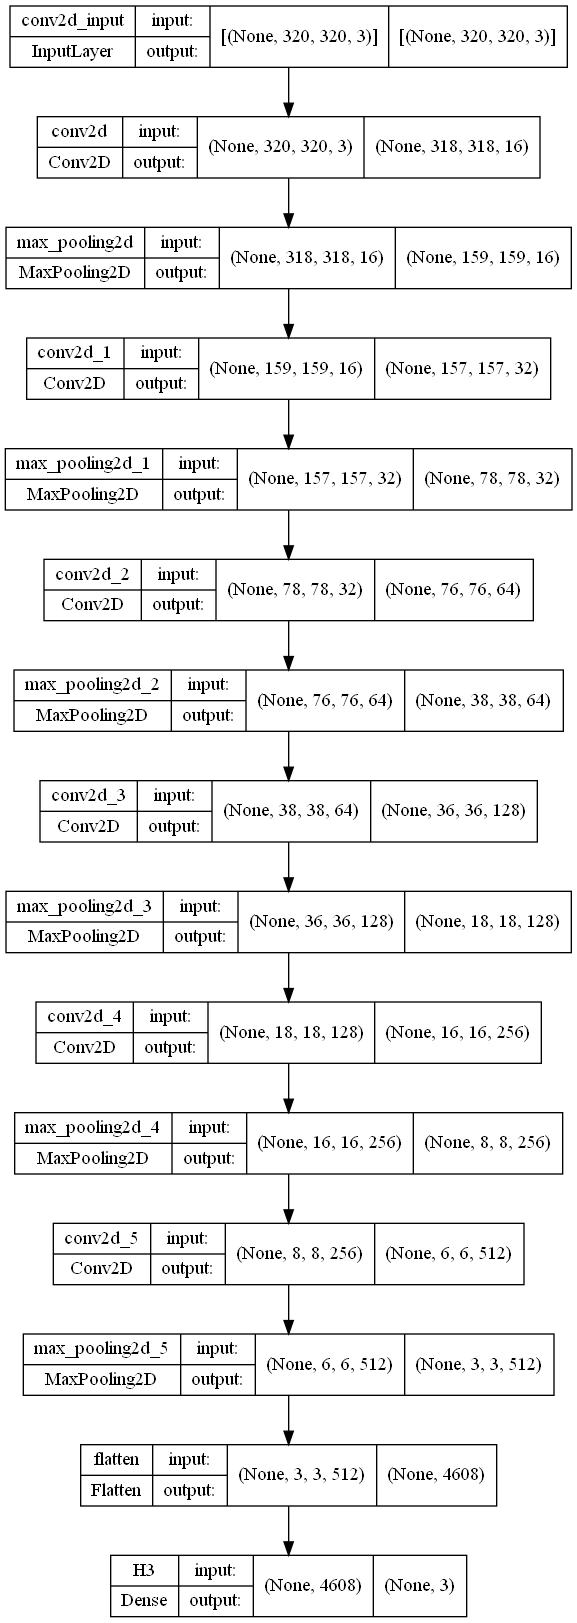

In [7]:
#@title Encoder
def get_encoder(act='relu', dim=3, s=1):  
  return Sequential([
      
     Conv2D(16,  (3, 3), activation=act,  input_shape=SHAPE_IN, strides=s),                
     MaxPooling2D(),
      
     Conv2D(32,  (3, 3), activation=act,  strides=s),
     MaxPooling2D(),
      
     Conv2D(64,  (3, 3), activation=act,  strides=s),
     MaxPooling2D(),
      
     Conv2D(128,  (3, 3), activation=act, strides=s),
     MaxPooling2D(),
      
     Conv2D(256,  (3, 3), activation=act, strides=s),
     MaxPooling2D(),
     
     Conv2D(512,  (3, 3), activation=act, strides=s),
     MaxPooling2D(),
      
     Flatten(name='flatten'), 
     
     Dense(dim, name='H3'),                    
    ], name='encoder')
utils.plot_model(get_encoder(), dpi=96, show_shapes=True)

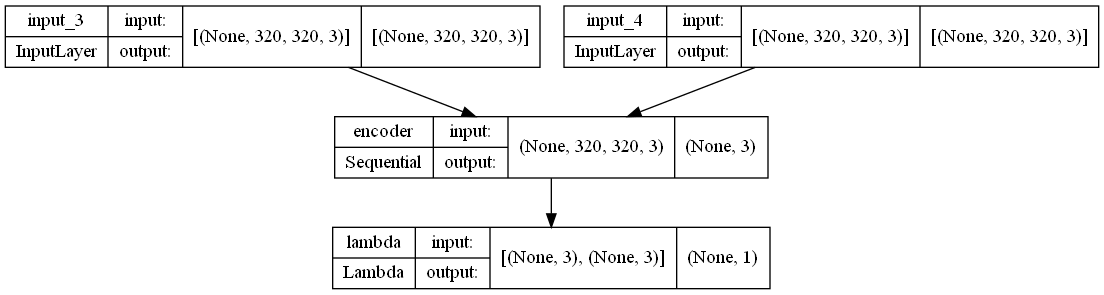

In [9]:
#@title Сиамская нейронная сеть

def get_siam(act='relu', dim=3):

  img_a = Input(shape=SHAPE_IN)
  img_b = Input(shape=SHAPE_IN)

  encoder = get_encoder(act=act, dim=dim)

  vecs_a = encoder(img_a)
  vecs_b = encoder(img_b)
  
  def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

  def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

  distance = Lambda(euclidean_distance, 
                    output_shape=eucl_dist_output_shape)([vecs_a, vecs_b])

  def loss_siam(distance):
    def contrastive_loss(y_true, y_pred):
      margin = 1.
      loss = K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))
      return loss
    return contrastive_loss
  
  model = Model([img_a, img_b], distance)

  
  model.compile(optimizer="Adam", loss=loss_siam(distance))

    
  return model, encoder

utils.plot_model(get_siam()[0], dpi=96, show_shapes=True)

## Обучение

In [10]:
#@title График обучения
def show_loss(fname):
    sns.set_style('darkgrid')
    plt.figure(figsize=(12,8))
    #for i, (k, v) in enumerate(h.history.items()):
    #  if 'lr' == k: continue
    loss, vall, x, lr = [], [], [], 0.001
    with open(fname, 'r') as f:
      for v in f:
        logs = v.split(',')
        loss.append(float(logs[1]))
        vall.append(float(logs[2]))
        if lr - float(logs[3]) != 0:
            x.append(int(logs[0]))
        lr = float(logs[3])
    plt.title(f'График ошибки')
    plt.plot(loss, label='Обучение')
    plt.plot(vall, label='Проверочная')
    plt.xlabel('Эпоха')
    y = [vall[i] for i in x]
    plt.scatter(x, y, label='Увеличение скорости', c='red')
    plt.legend()
    plt.show()

In [11]:
#@title Колбэк

class SaveLoss(Callback):

      def on_epoch_begin(self, epoch, logs): 
        self.e = epoch
        
      def on_epoch_end(self, epoch, logs):
        self.loss = logs['loss']
        logs['lr']=self.model.optimizer.learning_rate.numpy()
        with open(self.floss, 'a') as f:
              f.write(f'{epoch},%(loss)s,%(val_loss)s,%(lr)s\n' % logs) 


def call_back (name, pred):

  save = SaveLoss()
  save.floss = DATA_PATH + os.path.sep + f'{name}.csv'
  if os.path.exists(save.floss):
    os.remove(save.floss)
  return [  save,
            # Динамический lr
            ReduceLROnPlateau(monitor='val_loss', factor=0.5,# Колбэк дообучения
                              patience=5, min_lr=0.0000000001, verbose=0), 
            # Сохранение лучших весов
            ModelCheckpoint(monitor='val_loss', 
                            verbose=0, 
                            filepath = DATA_PATH+os.path.sep+f'{name}.hdf5', 
                            save_best_only=True, 
                            save_weights_only=True)
         ]



In [135]:
#@title Сиамская сеть
siam, enc = get_siam()
h = siam.fit(train_gen, epochs=EPS, 
             callbacks=call_back('final', enc.predict), validation_data=test_gen)

Epoch 1/100
141/141 [==============================] - 51s 355ms/step - loss: 0.2750 - val_loss: 0.2705 - lr: 0.0010
Epoch 2/100
141/141 [==============================] - 50s 352ms/step - loss: 0.2460 - val_loss: 0.2535 - lr: 0.0010
Epoch 3/100
141/141 [==============================] - 50s 352ms/step - loss: 0.2344 - val_loss: 0.2378 - lr: 0.0010
Epoch 4/100
141/141 [==============================] - 50s 352ms/step - loss: 0.2200 - val_loss: 0.2284 - lr: 0.0010
Epoch 5/100
141/141 [==============================] - 50s 351ms/step - loss: 0.2064 - val_loss: 0.2370 - lr: 0.0010
Epoch 6/100
141/141 [==============================] - 50s 351ms/step - loss: 0.1975 - val_loss: 0.2487 - lr: 0.0010
Epoch 7/100
141/141 [==============================] - 50s 351ms/step - loss: 0.1825 - val_loss: 0.2248 - lr: 0.0010
Epoch 8/100
141/141 [==============================] - 50s 351ms/step - loss: 0.1678 - val_loss: 0.2167 - lr: 0.0010
Epoch 9/100
141/141 [==============================] - 50s 351ms

Epoch 67/100
141/141 [==============================] - 49s 351ms/step - loss: 0.0080 - val_loss: 0.2251 - lr: 9.7656e-07
Epoch 68/100
141/141 [==============================] - 49s 350ms/step - loss: 0.0079 - val_loss: 0.2251 - lr: 9.7656e-07
Epoch 69/100
141/141 [==============================] - 50s 351ms/step - loss: 0.0079 - val_loss: 0.2251 - lr: 9.7656e-07
Epoch 70/100
141/141 [==============================] - 49s 351ms/step - loss: 0.0079 - val_loss: 0.2252 - lr: 9.7656e-07
Epoch 71/100
141/141 [==============================] - 49s 351ms/step - loss: 0.0079 - val_loss: 0.2252 - lr: 4.8828e-07
Epoch 72/100
141/141 [==============================] - 49s 351ms/step - loss: 0.0079 - val_loss: 0.2252 - lr: 4.8828e-07
Epoch 73/100
141/141 [==============================] - 49s 351ms/step - loss: 0.0079 - val_loss: 0.2252 - lr: 4.8828e-07
Epoch 74/100
141/141 [==============================] - 49s 350ms/step - loss: 0.0079 - val_loss: 0.2252 - lr: 4.8828e-07
Epoch 75/100
141/141 [==

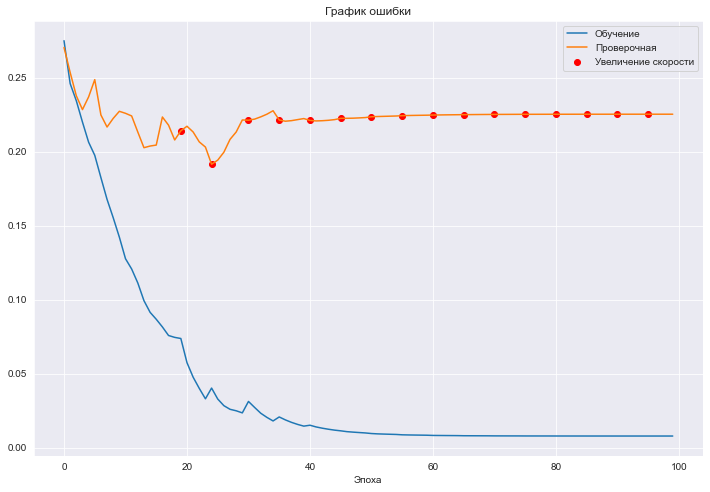

In [138]:
show_loss(DATA_PATH + os.path.sep + 'final.csv')

##  Экспорт

In [139]:
#@title Конвертация модели в с++
siam.save_weights(DATA_PATH + os.path.sep + 'final_end_100.hdf5')
from keras2cpp import export_model
my_model =  DATA_PATH + os.path.sep + 'my.model'
export_model(enc, my_model)

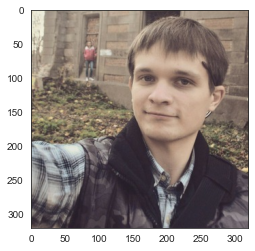

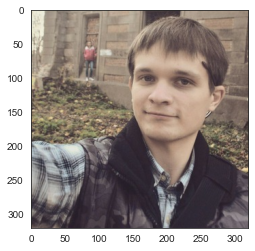

python: [[-0.5956546   0.2550374  -0.25067544]]
keras2cpp data\my.model data\test.npy
c++: [-0.597403,0.25884,-0.251386]


1

In [144]:
#@title Тест предсказания с с++
fname = 'C:\\Users\\User\\Desktop\\i99QImnBxBCkQysBLX61ECM2GHBWjhEHJdwGV_1pSMPCpRqfRMj2IYcPO7Ls4VKhJaUSxvzwV_gjfk8rEjxMJ2yMmo_cA3OUPjNr24UtvP41VjEL18ELs0ya2gHh5Jq9R2-omZ1-29x_ze4RQWOnH6xM8F9xK4Ozqmxt_THxLq0A5Mhbf6ICsASfEytrmK_dB8WBOiwLp428s1bTTJPEvOFtq.jpg'
test_npy = DATA_PATH + os.path.sep+ 'test'
arr = Image.open(fname)
arr = arr.convert('RGB')
sns.set_style('white')
plt.imshow(arr)
plt.show()

k = arr.size[0]/arr.size[1] 
if k <= 0.9 or k >= 1.1:
    x = crop_img(arr)
else:
    x = extend_img(arr)
x = x/255.
np.save(test_npy, x)
    
x = np.load(f'{test_npy}.npy')
plt.imshow(x)
plt.show()

x.resize(1, *SHAPE_IN)
print('python:', enc.predict(x)) 

cmd = f'keras2cpp {my_model} {test_npy}.npy'
print(cmd)
process = os.popen(cmd)
print('c++:', process.read())
process.close()            

In [142]:
#@title Экспорт тестовых фото
list_dirs = os.listdir(NORM_PATH)
for i in tqdm(range(COUNT_EXP)):
    num_actor = random.choice(range(len(list_dirs)))
    actor = list_dirs[num_actor]
    
    list_face = os.listdir(NORM_PATH + os.path.sep + actor)
    fname = os.path.join(NORM_PATH, actor, random.choice(list_face))
    x = Image.open(fname)
    x = x.convert('RGB')
    x = np.array(x)
    x.resize(1, *SHAPE_IN)
    p = enc.predict(x)
    
    name = f'{i+1:04d}.webp'
    with open(DATA_PATH+os.path.sep+'fake.csv', 'a') as f:
        f.write(f'"{i+1}","-{num_actor+1}","fake/{name}","%s","%s","%s","1",,,\n' % (*p[0],)) 
   
    jpg = Image.open(fname)
    jpg = jpg.resize((160,160), Image.ANTIALIAS)
    jpg.save(os.path.join(PATH_EXP, name), format="webp") 

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_2788\2294163831.py:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  jpg = jpg.resize((160,160), Image.ANTIALIAS)
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:48<00:00, 20.66it/s]


## Результат

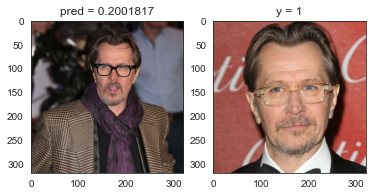

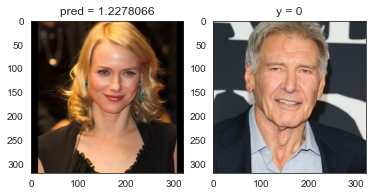

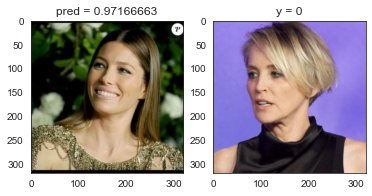

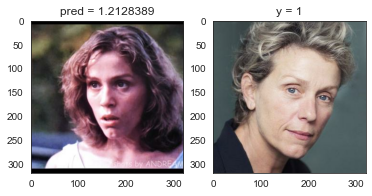

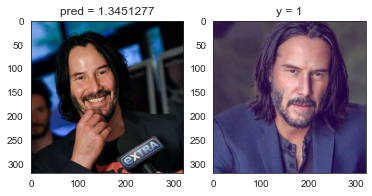

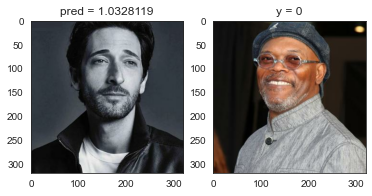

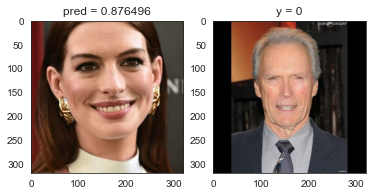

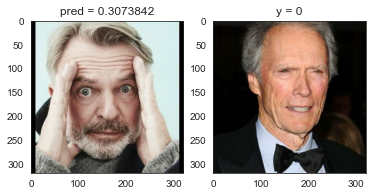

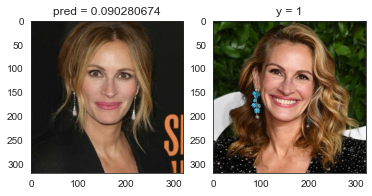

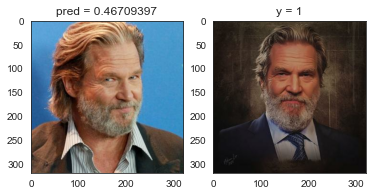

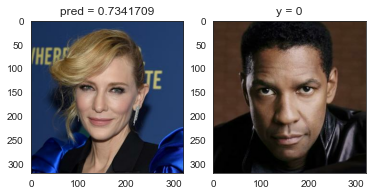

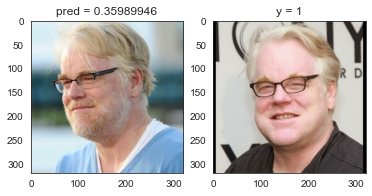

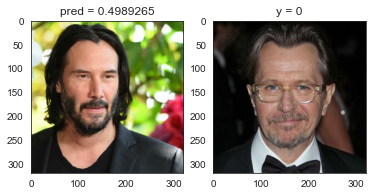

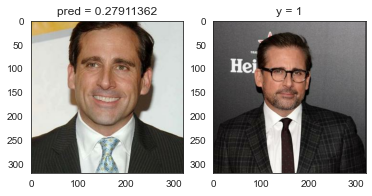

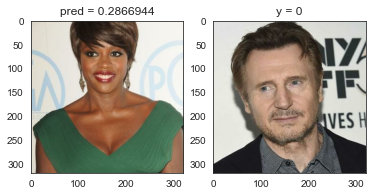

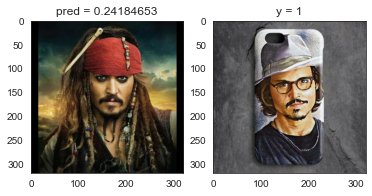

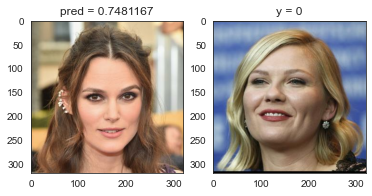

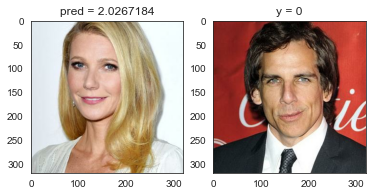

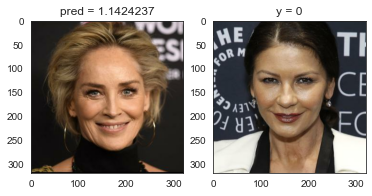

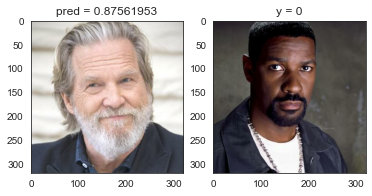

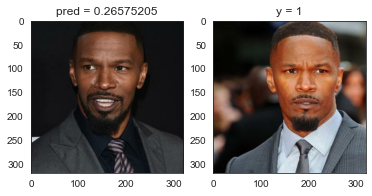

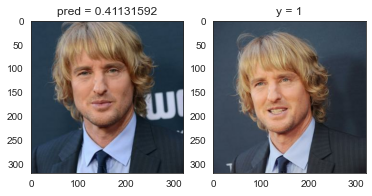

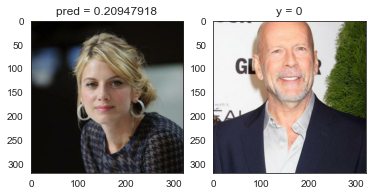

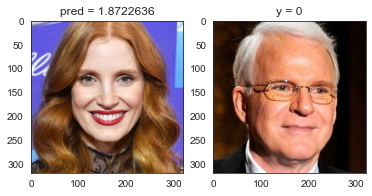

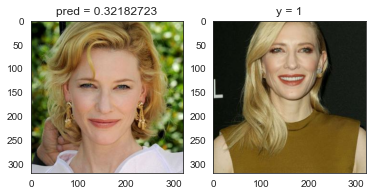

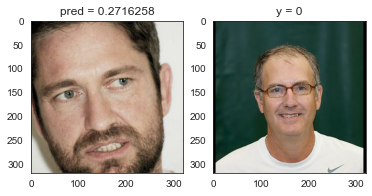

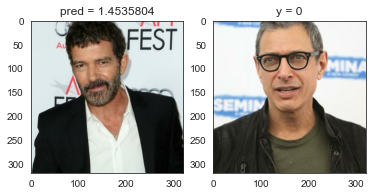

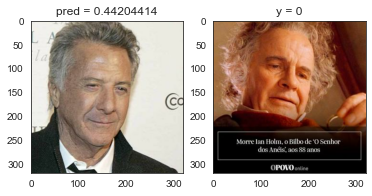

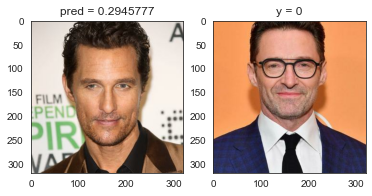

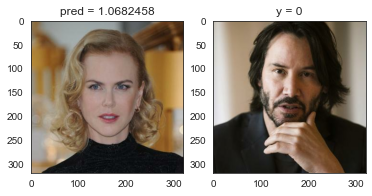

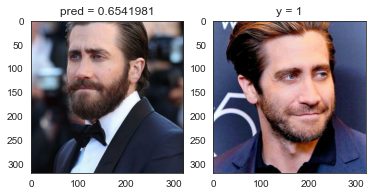

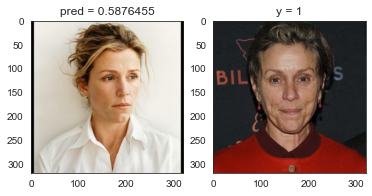

In [228]:
#@title Точность сети
iter_test = iter(test_gen)
(a, b), y = next(iter_test)
y = y.numpy().ravel()
pred = siam.predict([a, b]).ravel()
count_true = 0
for i in range(len(y)):
    count_true += (y[i] == 1 and pred[i] >= .5) or (y[i] == 0 and pred[i] < .5)
    plt.subplot(121)
    plt.title('pred = %s' % pred[i])
    plt.imshow(a[i])
    plt.subplot(122)
    plt.imshow(b[i])
    plt.title('y = %s' % int(y[i]))
    plt.show()

In [229]:
count_true/len(y)

0.34375